In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import MonthLocator

<class 'pandas.core.frame.DataFrame'>
Index: 405 entries, 2023-11-26 to 2023-07-30
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   valid    405 non-null    int64
 1   invalid  405 non-null    int64
dtypes: int64(2)
memory usage: 9.5+ KB
            valid  invalid
arr_date                  
2023-11-26     76      217
2022-12-20    420     1385
2023-01-18    505     1696
2022-12-19    517     1355
2023-11-20    593     1257
...           ...      ...
2023-06-11   1130     1089
2023-06-25   1131     1095
2023-07-23   1132     1141
2023-07-09   1138     1137
2023-07-30   1143     1149

[405 rows x 2 columns]


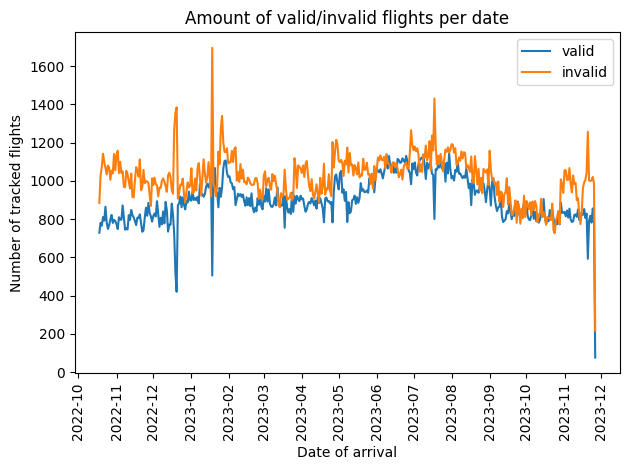

In [4]:
def group_by_date(df):
    df['arr_date'] = pd.to_datetime(df['arr_time_utc']).dt.date
    df = df.groupby(['arr_date']).size().sort_values(ascending=True).reset_index(name='counts')
    df.set_index('arr_date', inplace=True)
    return df


def analyze_records_by_day():
    valid_flights = pd.read_csv("../extract/data/history/flightsHistory.csv")
    invalid_flights = pd.read_csv("../extract/data/history/flightsHistory_invalid.csv")
    valid_flights = group_by_date(valid_flights).rename(columns={"counts": "valid"})
    invalid_flights = group_by_date(invalid_flights).rename(columns={"counts": "invalid"})
    flights = pd.merge(valid_flights, invalid_flights, how='outer', on='arr_date')
    flights.info()
    print(flights.head(500))
    ax = flights.plot()
    ax.xaxis.set_major_locator(MonthLocator())
    plt.xticks(rotation=90)
    plt.title("Amount of valid/invalid flights per date")
    plt.ylabel("Number of tracked flights")
    plt.xlabel("Date of arrival")
    plt.tight_layout()
    plt.show()

analyze_records_by_day()